In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import os

import tensorflow as tf
import keras
from keras import layers, regularizers
import pickle


In [3]:
import math
from collections import deque
import random

In [4]:
data = pd.read_csv("C:\\Users\\Joe\\Desktop\\Tufts Fall 2022\\CS 138\\FInal Project\\Data\\simple_data.csv")


In [5]:
data.head()

,Hour,Wind,Solar,Total Gen,Load,Price
0,0,10.07,0.0,10.07,11.39,34.46
1,1,10.17,0.0,10.17,10.98,32.71
2,2,10.16,0.0,10.16,10.62,34.16
3,3,10.25,0.0,10.25,10.47,32.64
4,4,10.45,0.0,10.45,10.60,32.42


In [6]:
data_arr = np.array(data)

In [7]:
data_arr[0]

array([ 0.  , 10.07,  0.  , 10.07, 11.39, 34.46])

In [8]:
#Town Parameters
avg_home_hourly_kw = 30/24
town_size = 10000
mwh_town_avg = town_size * avg_home_hourly_kw / 1000

turbine_swept_area = 9500 #m^2
avg_air_density = 1.225
turbine_lcoe = 50 #$/MW

panel_size = 1 #square meter
solar_coeff = .75
solar_eff = .20
solar_lcoe = 25 #$/mw


grid_import_rate = 1.25
grid_export_rate = .75

In [9]:
PRICE_BETA = -.70
PRICE_INCR = 0.1

In [10]:
REPLAY_MEMORY_SIZE = 12000 #how many steps to keep for training
MIN_REPLAY_MEMORY_SIZE = 40 #minimum number of samples before start of training
MINIBATCH_SIZE = MIN_REPLAY_MEMORY_SIZE #how many hours to use for training the model
UPDATE_TARGET_EVERY = 1 #days
DISCOUNT = 1

In [11]:
#ACTIONS = [[j, k, l] for j in range(5) for k in range(2) for l in range(2)]
ACTIONS = [[j, k, l] for j in range(3) for k in range(2) for l in range(2)]
NUM_ACTIONS = len(ACTIONS)

In [12]:
STATE_LEN = 14

In [13]:
ACTIONS #agent picks index of list. First element in sublist is whether to sell power or charge the battery (excess power option), second option is to buy or discharge batery (deficient energy option)

[[0, 0, 0],
 [0, 0, 1],
 [0, 1, 0],
 [0, 1, 1],
 [1, 0, 0],
 [1, 0, 1],
 [1, 1, 0],
 [1, 1, 1],
 [2, 0, 0],
 [2, 0, 1],
 [2, 1, 0],
 [2, 1, 1]]

In [14]:
class Battery:

    def __init__(self, capacity, max_charge, max_discharge):
        self.capacity = capacity
        self.max_charge = max_charge
        self.max_discharge = max_discharge
        self.current_charge = 0

    def charge(self, energy):
        effective_charge = min(energy, self.max_charge)
        space = self.capacity - self.current_charge
        if space <= 0:
            return max(energy,0)
        else:
            self.current_charge += min(space,effective_charge)
            return max(energy-min(space,effective_charge),0)
    
    def discharge(self, energy):
        remaining = self.current_charge
        self.current_charge -= min(energy, remaining, self.max_discharge)
        return min(energy, remaining, self.max_discharge)

    def reset(self):
        self.current_charge = self.capacity

    def SoC(self):
        return self.current_charge/self.capacity


In [15]:
class Grid:

    def __init__(self, town_size, turbine_count, solar_panel_count,data):
        self.town_size = town_size
        self.turbine_count = turbine_count #these are deprecated for hte simple problem
        self.solar_panel_count = solar_panel_count #these are deprecated for the simple problem
        self.town_avg_load = self.town_size * avg_home_hourly_kw / 1000
        self.data = data.copy()
        #self.price_beta_mean = 0.25
        #self.price_beta_std = 0.05
        self.battery = Battery(self.town_size*avg_home_hourly_kw/1000*2,self.town_size*avg_home_hourly_kw/1000,self.town_size*avg_home_hourly_kw/1000)
        self.day = 0 #starting data index
        self.iterations = 24 #multiplier so that we can get data index to roll from one day to the next
        self.start_step = 0 #fixed
        self.time_step = self.start_step #start at 0
        self.data_ind = self.iterations*self.day

        self.consumer_banked_load = 0

        #self.start_inds = np.arange(0,len(self.data)-240,24)
        '''
        self.data['wind_power_MWH'] = self.data['wind_power_MWH'] * self.turbine_count
        self.data['solar_power_MWH'] = self.data['solar_power_MWH'] * self.solar_panel_count
        self.data['generation'] = self.data['wind_power_MWH'] + self.data['solar_power_MWH']
        self.data['base_load'] = self.data['load_pct_mean'] * self.town_avg_load
        '''
        self.data['std_load'] = (self.data['Load'] - min(self.data['Load']))/ (max(self.data['Load']) - min(self.data['Load']))
        self.data['std_gen'] = (self.data['Total Gen'] - min(self.data['Total Gen']))/ (max(self.data['Total Gen']) - min(self.data['Total Gen']))
        self.data['std_price'] = ((self.data['Price'] - min(self.data['Price']))/ (max(self.data['Price']) - min(self.data['Price'])))
        

        #data ind is the index for data for that day. It goes up by one each time step

        self.states = []
        self.days = []
        self.actions = []
        self.energy_buys = []
        self.energy_sales = []
        self.rewards = []
        self.ep_reward = []
        self.actions_received = []
        
        
    def calc_generation(self): #this can stay since we still need to pull in how much power is being generated at each hour
        energy = self.data['Total Gen'].iloc[self.data_ind]
        return energy

    '''def calc_gen_cost(self): Remove this since we are no longer including the cost of energy generation
        wind_cost = turbine_lcoe * self.data['wind_power_MWH'].iloc[self.data_ind]
        solar_cost = solar_lcoe * self.data['solar_power_MWH'].iloc[self.data_ind]
        total_cost = wind_cost + solar_cost
        return total_cost'''

    def calc_base_load(self): #This can stay as well since we need the load
        base_load = self.data['Load'].iloc[self.data_ind]
        return base_load
        
        

    def build_state(self, append=True):
        #gather inputs from methods, standarize
        

        #SIMPLIFIED -- the agent just needs to signal when to charge and when to discharge the battery. It will receive as a state: the load, the generation, cur_price,the battery state of charge, the hour of day
        #                                                                                                # the next 4 hours of: load, generation, price
        

        bat_charge = self.battery.SoC()
        inds = [(self.data_ind+i) % 24 for i in range(4)]
        generation = [self.data['std_gen'].iloc[ind] for ind in inds]
        #generation = [self.data['std_gen'].iloc[self.data_ind], self.data['std_gen'].iloc[self.data_ind+1], self.data['std_gen'].iloc[self.data_ind+2]]
        loads = [self.data['std_load'].iloc[ind] for ind in inds]
        prices = [self.data['std_price'].iloc[ind] for ind in inds]

        generation = np.array(generation) * np.random.normal(1,.15)
        loads = np.array(loads) * np.random.normal(1,.15)
        prices = np.array(prices) * np.random.normal(1,.15)

        current_hour = self.time_step/(self.iterations-1)

        cb_load = self.consumer_banked_load/self.town_avg_load
        
        state = np.concatenate(([bat_charge],[cb_load] ,[gen for gen in generation], [load for load in loads], [price for price in prices]))

        #state = np.array([load, bat_charge, generation, cur_wind, cur_ghi, next_wind, next_ghi,cur_rt_price, next_rt_price, current_hour])
        
        if append:
            self.states.append(state)

        return state

    def step(self, action_num):
        
        #action num comes from agent
        self.actions.append(action_num)
        self.days.append(self.day)
        
                
        actions = ACTIONS[action_num]
        

        #price_action = actions[0]
        price_action = actions[0]
        excess_action = actions[1]
        deficient_action = actions[2]

        available_energy = self.calc_generation()
        #reward starts out as negative cost of energy
        #reward = -self.calc_gen_cost() DEPRECATED

        #calculate new load based on price elasticity

        base_load = self.calc_base_load()

        #shift load based on price
        degree_of_shift = (price_action -1)*1.5
        
        cur_price = self.data['Price'].iloc[self.data_ind]

        new_price = cur_price * (1+PRICE_INCR*degree_of_shift)
        #reward += total_load * (1+(price_action-2)/100) * cur_price

        new_load = base_load * (1+PRICE_INCR*degree_of_shift*PRICE_BETA)

        #if price is shifted lower, then the load will increase -- so future load should go down, if price is higher, than load will decrease, and future load goes up
        #We want the agent to learn to raise prieces when the price is high and load is high to avoid having to buy from the grid, and to lower prices when load is low to make more money
        #this somewhat conflicts with the battery -- we want it to charge the battery when load is low, and then discharge when load is high -- ideally the battery is discharged when load is its most expensive

        self.consumer_banked_load += base_load - new_load

        total_load = new_load + (self.consumer_banked_load/5)

        self.consumer_banked_load -= (self.consumer_banked_load/5)

        reward = total_load * new_price

        excess_generation = available_energy - total_load
                
        if excess_generation > 0: #if energy remains after we have satisfied load obligation
            if excess_action == 1: #if we signaled to charge the abttery
                excess_generation = self.battery.charge(excess_generation)  #charge the battery, return whatever is leftover
                
                reward += excess_generation * cur_price * grid_export_rate #sell whatever is returned from the battery at current price, which is reduced by the export rate
            else: #if we said not to charge the battery,
                
                reward += excess_generation * cur_price * grid_export_rate #sell the remainder
            energy_sold = excess_generation
            energy_bought = 0

        else: #if available energy is <= 0
            if deficient_action == 1:
                excess_generation += self.battery.discharge(-excess_generation)
            # if available energy is still negative (meaning we need more) then we must buy from the grid at raised price
            energy_bought = -excess_generation
            reward += excess_generation * cur_price * grid_import_rate
            energy_sold = 0

        self.energy_buys.append(energy_bought)
        self.energy_sales.append(energy_sold)

        if self.time_step == 23:
            self.day += 1

        self.time_step +=1
        self.data_ind += 1

        self.rewards.append(reward) #store all rewards at each step, this list never deleted
        self.ep_reward.append(reward) #store rewards of current episode, we return the sum at the last step

        if self.time_step <24:
            reward = 0
        else:
            reward = sum(self.ep_reward)
        

        #optional here
        terminal = self.time_step % self.iterations == 0
        #if terminal:
            # reward += abs(reward*self.battery.SoC() /2)
        
        state = self.build_state()

        return state, reward, terminal

    def reset(self, day=None):

        if day == None:
            self.day = 0
        else:
            self.day = day
        #print('Day:', self.day)

        self.time_step = self.start_step
        self.data_ind = self.iterations*self.day
        self.ep_reward = []

        return self.build_state()

    def reset_all_lists(self):
        self.states = []
        self.days = []
        self.actions = []
        self.energy_buys = []
        self.energy_sales = []
        self.rewards = []
        self.actions_received = []

        

        



In [15]:
test_env = Grid(10000,100,100, data)

In [16]:
len(test_env.data)/24

1.0

In [17]:
test_env.battery.SoC()

0.0

In [16]:
class Agent:

    def __init__(self):
        
        #Main model for predicting q values
        self.model = self.create_model()

        #target model for giving Ys
        self.target_model = self.create_model()
        self.target_model.set_weights(self.model.get_weights())

        self.replay_memory = deque(maxlen=REPLAY_MEMORY_SIZE)

        self.target_update_counter = 0

        self.rewards_list = []
        self.actions_taken = []

    def create_model(self):
        model = keras.Sequential()

        model.add(layers.Input(shape=STATE_LEN))
        model.add(layers.Dense(30, activation='relu'))
        #model.add(layers.Dropout(0.1))
        model.add(layers.Dense(30, activation='relu'))
        #model.add(layers.Dropout(.1))
        model.add(layers.Dense(NUM_ACTIONS,activation='linear'))

        model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.1), metrics=['accuracy'])

        return model

    def update_replay_memory(self, transition):
        self.replay_memory.append(transition)

    def train(self, terminal_state, step):
        if len(self.replay_memory) < MIN_REPLAY_MEMORY_SIZE:
            return
        #get minibatch of random samples from replace memory
        minibatch = random.sample(self.replay_memory, MINIBATCH_SIZE)

        #Get current states from the minibatch and then query NN model for q values
        current_states = np.array([transition[0] for transition in minibatch])
        current_qs_list = self.model.predict(current_states, verbose =0)

        # Get future states from teh minibatch, then query the target NN for q values  for the TD update
        new_current_states = np.array([transition[3] for transition in minibatch])
        future_qs_list = self.target_model.predict(new_current_states, verbose = 0)

        x = []
        y = []

        #now we can create the X's and Y's for training

        for index, (current_state, action, reward, new_current_state, terminal) in enumerate(minibatch):

            #if not a terminal state, then get new q from future states, otherwise set it to 0
            if not terminal:
                max_future_q = np.max(future_qs_list[index])
                new_q = reward + DISCOUNT * max_future_q

            else:
                new_q = reward

            #Update Q values for given state

            current_qs = current_qs_list[index]
            current_qs[action] = new_q

            #add to draining data
            x.append(current_state)
            y.append(current_qs)

        #fit on all the samples

        self.model.fit(np.array(x), np.array(y), batch_size = MINIBATCH_SIZE, verbose = 0, shuffle=False) 

        if terminal_state:
            self.target_update_counter += 1

        if self.target_update_counter > UPDATE_TARGET_EVERY:
            self.target_model.set_weights(self.model.get_weights())
            self.target_update_counter = 0
        
    def get_qs(self, state):
        sample = []
        for i in range(1):
            sample.append(state)
        sample = np.array(sample)
        return self.model.predict(sample, verbose=0)[0]
        

In [19]:
test_env = Grid(10000,100,100, data)

In [20]:
test_agent = Agent()

In [17]:
all_episode_rewards = []

In [18]:

for i in range(8,9):
    np.random.seed(i)
    start_epsilon = .15
    episode_nums = 500
    epsilon = start_epsilon

    group_test_agent = Agent()
    group_test_env = Grid(10000,100,100,data)
    print('Iteration:', i-5)

    for episode in range(0,episode_nums): #each day is an episode
        #episode_rewards = []
        episode_reward = 0
        step = 0

        current_state =group_test_env.reset() 
        epsilon = max((((episode_nums-100)-episode)/(episode_nums-100))*start_epsilon,0)
         
        if episode % 20 == 0:
            print("EPISODE", episode)

        done = False
        while not done:

            if np.random.random() > epsilon : 
                action = np.argmax(group_test_agent.get_qs(current_state))
            else:
                action = np.random.randint(0, NUM_ACTIONS)

            new_state, reward, done = group_test_env.step(action)
            #step_rewards.append(reward)
            episode_reward += reward
            
            group_test_agent.update_replay_memory((current_state, action, reward, new_state, done))
            group_test_agent.train(done, step)

            current_state = new_state
            step += 1
        
        all_episode_rewards.append(episode_reward)

    with open(f'price_all_episode_rewards_at_{i-5}_iterations.pkl','wb') as f:
        pickle.dump(all_episode_rewards,f)
    #avg_episode_rewards.append(sum(episode_rewards)/len(episode_rewards))
                

Iteration: 3
EPISODE 0
EPISODE 20
EPISODE 40
EPISODE 60
EPISODE 80
EPISODE 100
EPISODE 120
EPISODE 140
EPISODE 160
EPISODE 180
EPISODE 200
EPISODE 220
EPISODE 240
EPISODE 260
EPISODE 280
EPISODE 300
EPISODE 320
EPISODE 340
EPISODE 360
EPISODE 380
EPISODE 400
EPISODE 420
EPISODE 440
EPISODE 460
EPISODE 480


In [17]:
with open("price_all_episode_rewards_at_1_iterations.pkl", 'rb') as f:
    price_simple_iteration_1 = pickle.load(f)

with open("price_all_episode_rewards_at_2_iterations.pkl", 'rb') as f:
    price_simple_iteration_2 = pickle.load(f)

with open("price_all_episode_rewards_at_3_iterations.pkl", 'rb') as f:
    price_simple_iteration_3 = pickle.load(f)    

In [18]:
iter_1 = np.array(price_simple_iteration_1)
iter_2 = np.array(price_simple_iteration_2)
iter_3 = np.array(price_simple_iteration_3)

In [23]:
all_rews = np.zeros((3,500))
all_rews[0] = iter_1
all_rews[1] = iter_2
all_rews[2] = iter_3

In [49]:
avg_rews = np.zeros((1,500)).reshape(1,500)
for i in range(500):
    avg_rews[0,i] = (all_rews[0][i]+all_rews[1][i] + all_rews[2][i])/3


In [50]:
avg_rews = list(avg_rews/1000)

<AxesSubplot: >

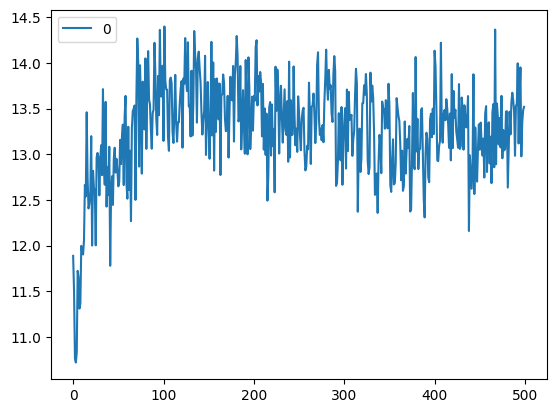

In [51]:
sns.lineplot(avg_rews)

<AxesSubplot: >

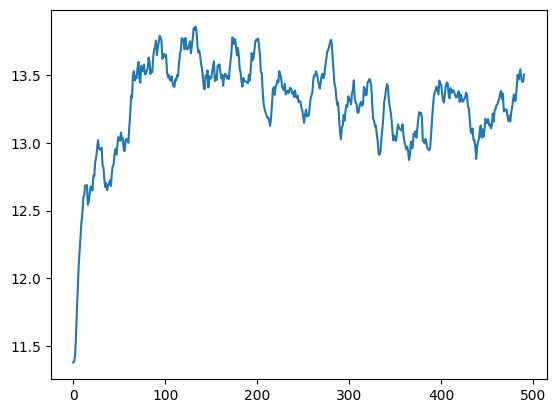

In [52]:

conv_rews = np.convolve(avg_rews[0], np.ones((10,))/10, mode='valid')
sns.lineplot(conv_rews)

In [40]:
rand_env = Grid(10000,100,100, data)

In [41]:
rand_step_rewards = []
rand_episode_rewards =[]

In [42]:
#start_epsilon = .05
episode_nums = 500
#epsilon = start_epsilon


for episode in range(0,episode_nums): #each day is an episode, 120 days
    #episode_rewards = []
    episode_reward = 0
    step = 0
    #epsilon = ((episode_nums-episode)/episode_nums)*start_epsilon
    current_state =rand_env.reset()  
    #if episode % 5 == 0:
        #print("EPISODE", episode)
    done = False
    while not done:

        
        action = np.random.randint(0, NUM_ACTIONS)

        new_state, reward, done = rand_env.step(action)
        rand_step_rewards.append(reward)
        episode_reward += reward
        #if step % 5 == 0:
            #print("step:", step)
        #test_agent.update_replay_memory((current_state, action, reward, new_state, done))
        #test_agent.train(done, step)

        current_state = new_state
        step += 1
    
    rand_episode_rewards.append(episode_reward)
#avg_episode_rewards.append(sum(episode_rewards)/len(episode_rewards))
            

In [43]:
print(np.mean(rand_episode_rewards))
print(min(rand_episode_rewards))
print(max(rand_episode_rewards))

12676.638031472101
11446.630241636205
14085.831219637705


In [53]:
rand_rews = np.array(rand_episode_rewards)/1000
results_rand = np.convolve(rand_rews, np.ones((10,))/10, mode='valid')

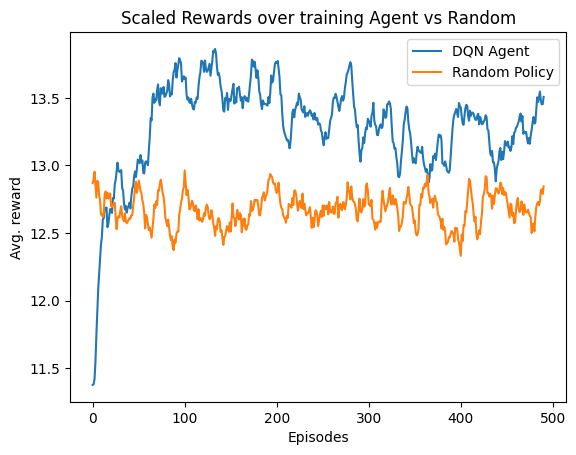

In [54]:
sns.lineplot(conv_rews, errorbar=None)
sns.lineplot(results_rand, errorbar=None)
plt.title('Scaled Rewards over training Agent vs Random')
plt.xlabel('Episodes')
plt.ylabel('Avg. reward')
plt.legend(labels=['DQN Agent','Random Policy'])
plt.show;

In [65]:
with open('actions__bat_3px_500episodes_se15.pkl', 'rb') as f:
    actions_taken = pickle.load(f)

In [81]:
with open('states__bat_3px_500episodes_se15.pkl','rb') as f:
    states_in = pickle.load(f)

In [82]:
states_arr = np.array(states_in)
states_arr.shape

(12500, 14)

In [87]:
battery_socs = states_arr[:,0]

In [88]:
battery_socs = battery_socs[0:12000].reshape(500,24)[350:]

In [89]:
avg_battery_socs = np.zeros(24)
for i in range(24):
    avg_battery_socs[i] = np.sum(battery_socs[:,i])/150

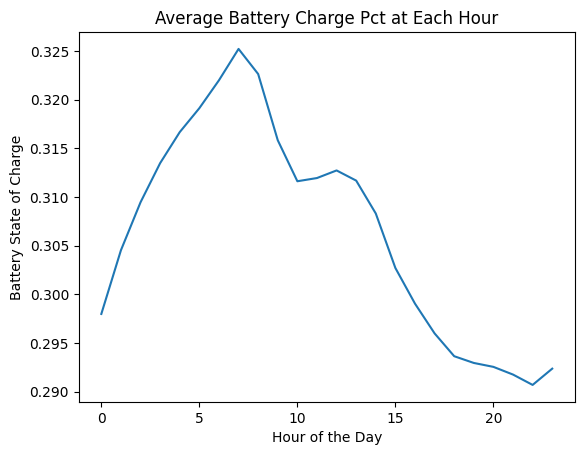

In [100]:
sns.lineplot(avg_battery_socs)
plt.title('Average Battery Charge Pct at Each Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Battery State of Charge')
plt.show;

In [66]:
actions_taken = np.array(actions_taken)

In [67]:
actions_taken_arr = actions_taken.reshape(500,24)

In [68]:
actions_taken_arr_last_eps = actions_taken_arr[350:]

In [69]:
actions_taken_arr_last_eps.shape

(150, 24)

In [94]:
price_actions = np.zeros((150,24))

In [95]:
for i in range(150):
    for j in range(24):
        price_actions[i][j] = ACTIONS[actions_taken_arr_last_eps[i][j]][0]-1

In [96]:
avg_price_actions = np.zeros(24)

for i in range(24):
    avg_price_actions[i] = np.sum(price_actions[:,i])/150

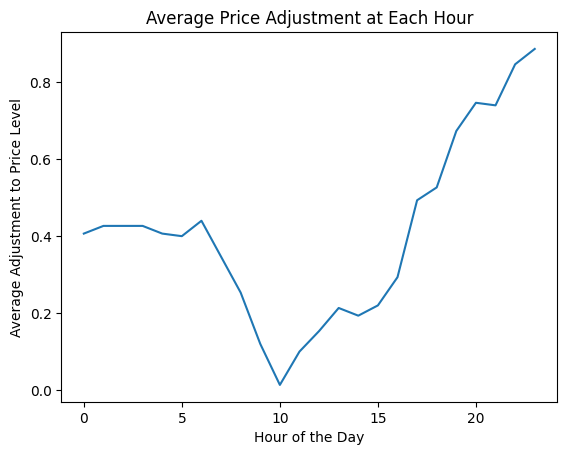

In [99]:
sns.lineplot(avg_price_actions)
plt.title('Average Price Adjustment at Each Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Adjustment to Price Level')
plt.show;